In [1]:
# Arcus performance metrics

In [2]:
from __future__ import print_function

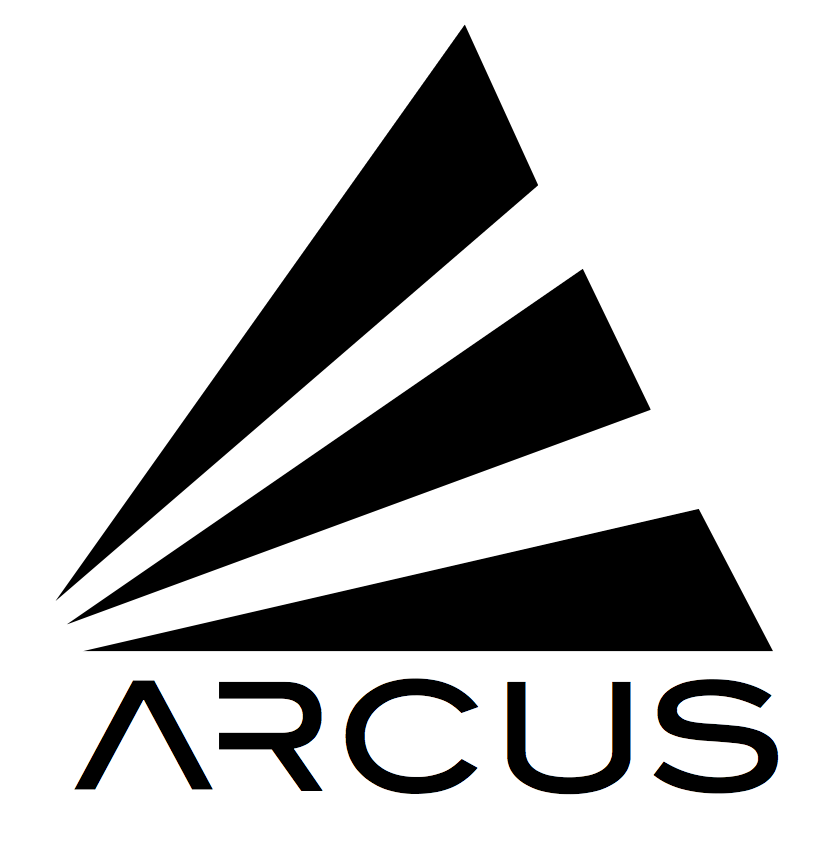

### Revision status: *towards Jan 18 freeze*
Last revision in version control:

- Author: Hans Moritz Guenther <hgunther@mit.edu>
- commit 067dc393fecc006a50c1908ba7635eff4a77406e
- Date:   Fri Jan 5 14:47:22 2018 -0500

**The version shown here is modified compared to the last commited revision.**

            

This document is git version controlled. The repository is available at https://github.com/hamogu/arcus.
See git commit log for full revision history.

Code was last run with:

- MARXS ray-trace code version 1.2.dev643 (commit hash: c7a3e480d6 from 2018-06-26)
- ARCUS python code version 0.0.dev153 (commit hash: 3d289c95aa from 2018-02-07)
- ARCUS CALDB version hash: 5590a73 (commited on 2018-05-15 )


In [3]:
from nbtemplate import display_header, display_codetoggle, get_path
display_header('CATmerrit.ipynb', status='towards Jan 18 freeze')

In this notebook, I show the effective area and resolution we can expect for Arcus with CAT gratings in the nominal design and according to the baseline tolerance budget.

### What's in this document and what is not
This document contains mostly results of simulations, not the code itself because many of the plots below require a grid of simulations, e.g. in for different energies, and take while to run. Thus, those grids are run in a separate process and the relevant results (e.g. the position of the final rays on the detector) is saved in a fits file. In this notebook we then parse these fits files to extract the relevant information.


## What's included in the simulations?
Details of the setup for the simulations are obviously defined in the python code, but a list of the most important effects that are included is here:

- On-axis, point-like source
- Spacecraft pointing with jitter
- Mirror with in-plane and out-of-plane scatter
- two optical axes, each of them used by one pair of channels
- SPO and grating facet positions identical with the mechanical design
- facets are flat (i.e. simulation includes finite size effects)
- CCDs are flat and have pixels
- CCD gaps between individual chips.

## Caveats

No simulation is perfect and there are many details of the Arcus design that are not or only very marginally relevant for the optical performance that are not covered in these simulations. The main caveats with respect to the optical design are:

- The SPO model for a mirror is simplified. Instead of a full surface in 3d, SPOs are represented but a single reflection in a plane. Comparison with experimental data shows that this is a valid approximation for on-axis sources, but cannot reproduce the effects expected for off-axis sources (most notably, the vignetting).
- Tolerances: Effective area and resolving power depend on the accurate placement of SPOs, CAT gratings and CCDs. The simulations here are mostly done placing all these elements at their nominal position.

In [4]:
import os
import sys
from glob import glob
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

import astropy
import astropy.coordinates
from astropy.table import Table, Column
import astropy.units as u

plt.style.use("fivethirtyeight")


In [5]:
from cycler import cycler

In [6]:
import marxs
from marxs.source import PointSource, FixedPointing
from marxs.analysis.gratings import resolvingpower_from_photonlist, weighted_per_order
import arcus
import arcus.arcus as instrum
from arcus.analysis.grid import apertures, orders_from_meta

In [7]:
tarc = Table.read(os.path.join(get_path('arcus'), 'raygridRAeff.fits'))
tarc.orders = orders_from_meta(tarc.meta)
tper = Table.read(os.path.join(get_path('arcus'), 'raygrid-perfectRAeff.fits'))
tper.orders = orders_from_meta(tper.meta)

Reading config file with path definitions: ['../site.cfg']
Reading config file with path definitions: ['../site.cfg']


In [8]:
print('Files were written with')
print('MARXS version', tarc.meta['MARXSVER'])
print('ARCUS version', tarc.meta['ARCUSVER'])
print('ARCUS inpudata git hash', tarc.meta['ARCDATHA'])
print('NOTE THAT THESE VERSIONS CAN BE DIFFERENT FROM THE LAST TIME THE NOTEBOOK WAS RUN')


Files were written with
MARXS version 1.2.dev626
ARCUS version 0.0.dev144
ARCUS inpudata git hash 54f5177
NOTE THAT THESE VERSIONS CAN BE DIFFERENT FROM THE LAST TIME THE NOTEBOOK WAS RUN


## Effective area

In [9]:
def plot_aeff(tab, aeff, plot_orders, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    for o in plot_orders: #, colorcycle):
        if o !=0:
            ax.plot(tab['wave'], aeff[:, tab.orders == o], label='order {0}'.format(o))
        else:
            ind0 = (tab.orders == 0)
            ax.plot(tab['wave'], aeff[:, ind0], 'k:', label='0th order')
    ax.plot(tab['wave'], np.sum(aeff[:, tab.orders != 0], axis=1), 
            'k-', label='all dispersed\norders')

    temp = ax.set_xlim([8, 55])
    return ax

Reading config file with path definitions: ['../site.cfg']
Reading config file with path definitions: ['../site.cfg']


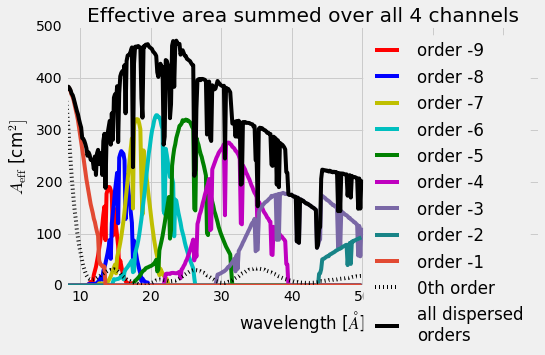

In [10]:
    plt.rc('axes', prop_cycle=(cycler('linestyle', ['-', '--', ':']) * 
                           cycler('color', ['r', 'b', 'y', 'c', 'g', 'm', '#7A68A6', '#188487', '#E24A33'])))
    # Do the same plot but split up by energy ranges
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    plot_aeff(tper, tper['Aeff4'], np.arange(-9, 1), ax)
    ax.set_title('Effective area summed over all 4 channels')
    fig.subplots_adjust(bottom=0.13, left=0.13, top=.85)
    ax.set_xlim([8, 75])
    ax.legend()
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('$A_\mathrm{eff}$ [cm$^2]$')
    fig.savefig(os.path.join(get_path('figures'), 'Aeff_16CCDs.png'), dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(get_path('figures'), 'Aeff_16CCDs.pdf'))

Effective area curve for Arcus based on the instrument setup and nominal alignment for every element. The effective area for all four channels is added. The contribution of individual grating orders is shown with colored curves. Each of the curves has a number of dips in it when an order falls into a chip gap. For any individual channel, the effective area drops to 0 in this case, but the channels are placed such the the chip gaps do not coincide in all of them, so the summed effective area suffers, but some signal is still detected.

The black curve sums the effective area of all detected dispersed orders, irrespective of their spectral resolving power. However, for most of the wavelength range, only orders that are very similar in resolving power (e.g. orders 4 and 5 at 30 $\unicode{xC5}$) contribute anyway. The only exception to this rule is the region around 12 $\unicode{xC5}$, where both order 1 and 9 contribute to the observed signal, with (as we will see below) significantly different $R$.

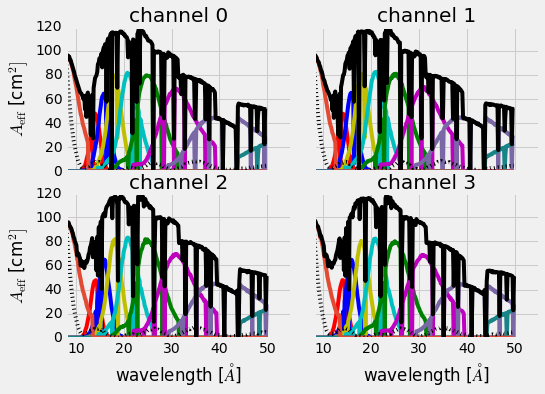

In [11]:
    # Do the same plot but split up by energy ranges
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
    for i, a in enumerate(apertures):
        ax = axes[np.unravel_index(i, axes.shape)]
        plot_aeff(tper, tper['Aeff'][:, i, :], np.arange(-9, 1), ax)
        ax.set_title('channel {}'.format(a))
    for i in [0, 1]:
        axes[1, i].set_xlabel('wavelength [$\AA{}$]')    
        axes[i, 0].set_ylabel('$A_\mathrm{eff}$ [cm$^2]$')
    fig.subplots_adjust(bottom=0.13, left=0.13, top=.85, wspace=0.1, hspace=0.15)
    
    #fig.savefig(os.path.join(get_path('figures'), 'Aeff_16CCDs.png'))
    #fig.savefig(os.path.join(get_path('figures'), 'Aeff_16CCDs.pdf'))

This plot shows the effective area for each of the four channels separately, using the same color coding as above. The channels are very similar and at this scale the difference can hardly be seen, but in particular there is a slight offset in the position of the chip gaps between channel 0 and 1 on the one side and 2 and 3 on the other. Note that for each order, the effective area drops to 0, when the order falls into a chip gap, but the effective area summed over all orders does not, at least in those regions where more than one order contributes signal.

## Spectral resolving power

I define the resolving power as:
$R = \frac{\lambda}{\Delta \lambda} = \frac{d_x}{FWMH}$
where $\lambda$ is the wavelength of a spectral line with negligible intrinsic
width, and $\Delta \lambda$ is the observed width of this feature. Since the
detector does not give the wavelength directly, $d_x$ and the $FWHM$ are linear
distances measured as follows: Events that hit a CCD are projected (not propagated, that would bring them out of focus) into a plane. The $FWMH$ is the full width at half maximum of the event distribution and $d_x$ is the distance between
the center of a diffracted order and the zeroth order.
Since the CCDs are flat and do not follow the Rowland circle exactly, the $R$ is somewhat lower than the $R$ expected on the Rowland circle. However, this effect is so small that it is negligible in practice. There is one problem with this procedure: If the center of the photon distribution is very close to a chip gap, then only a faction of the true distribution is visible on the chip and naturally the $FWHM$ of this distribution will be narrower than the true distribution. Thus, we also calculate the $R$ for a cylindrical detector on the Rowland circle and use the $R$ derived this way for positions close to the chip edge.

In [12]:
def plot_res(tab, res, ax=None, orders=np.arange(-9, -1)):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    for o in orders:
        i = tab.orders == o
        ax.plot(tab['wave'], res[:, i], label='order {0}'.format(tab.orders[i][0]))
        
    temp = ax.set_xlim([8, 55])
    return ax

Reading config file with path definitions: ['../site.cfg']
Reading config file with path definitions: ['../site.cfg']


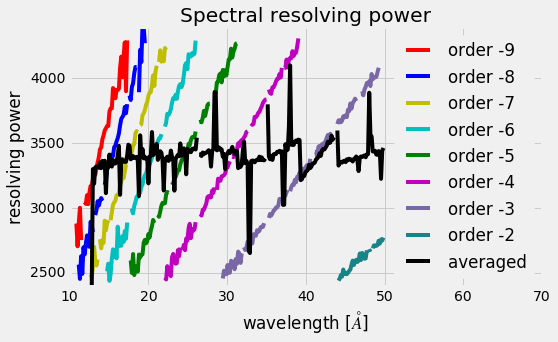

In [13]:
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ax = plot_res(tper, tper['R4'], ax)
    ax.plot(tarc['wave'], tarc['R_disp'], 'k', label='averaged')
    ax.legend()
    temp = ax.set_title('Spectral resolving power')
    #ax.plot(wave, np.ma.average(res_ma[:, 0, :-1], weights=aeff[:, :-1], axis=1), 'k:')
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('resolving power')
    ax.set_xlim(10., 70.)
    ax.set_ylim(2400, 4400)
    fig.subplots_adjust(bottom=0.13, left=0.13, top=.85)
    fig.savefig(os.path.join(get_path('figures'), 'respower.png'), dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(get_path('figures'), 'respower.pdf'))

Spectral resolving power for individual orders. The resolving power is only calculated if a certain minimum number of photons is detected in an order. If most photons fall into a chip gap, then values on the curve might be missing.

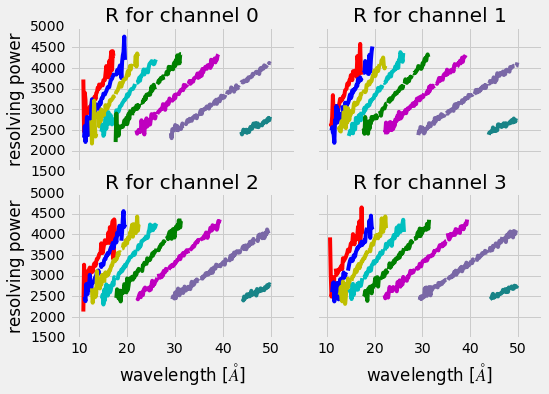

In [14]:
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
    for i, a in enumerate(apertures):
        ax = plot_res(tper, tper['R'][:, i, :], axes[np.unravel_index(i, axes.shape)])
        temp = ax.set_title('R for channel {}'.format(a))
        #ax.plot(wave, np.ma.average(res_ma[:, 0, :-1], weights=aeff[:, :-1], axis=1), 'k:')

    for i in [0, 1]:
        axes[1, i].set_xlabel('wavelength [$\AA{}$]')    
        axes[i, 0].set_ylabel('resolving power')
    fig.subplots_adjust(bottom=0.13, left=0.13, top=.85, wspace=0.1, hspace=0.15)
    fig.subplots_adjust(bottom=0.13, left=0.13, top=.85)
    #fig.savefig(os.path.join(get_path('figures'), 'respower.png'))
    #fig.savefig(os.path.join(get_path('figures'), 'respower.pdf'))

Reading config file with path definitions: ['../site.cfg']
Reading config file with path definitions: ['../site.cfg']


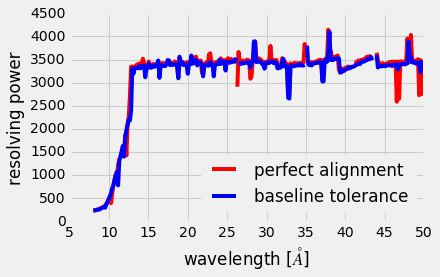

In [29]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(tper['wave'], tper['R_disp'], label='perfect alignment')
    ax.plot(tarc['wave'], tarc['R_disp'], label='baseline tolerance')
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('resolving power')
    fig.subplots_adjust(bottom=0.13, left=0.13, top=.85)
    ax.legend(loc='lower right')
    fig.savefig(os.path.join(get_path('figures'), 'averageres.png'))
    fig.savefig(os.path.join(get_path('figures'), 'averageres.pdf'), bbox_inches='tight')


This figure shows the resolving power averaged over all channels and all dispersed spectral orders. When averaging, values are weighted by their respective effective area. There are some drops in $R$ that occur when a wavelength is observed where two orders with slightly different $R$ contribute and one of them falls into a chip gap for a certain wavelength. In the region $39-44\;\unicode[serif]{xC5}$ only a single order contributes, and so we see the $R$ rising with wavelength as in the previous plots. For small wavelengths $<12\unicode[serif]{xC5}$ very low orders contribute to the signal, bringing down the average $R$. 

The plot shows almost no difference between the perfect alignment and the the baseline alignment tolerance scenario. This is consistent with the results in the [Alignment budget memo](http://space.mit.edu/home/guenther/ARCUS/Tolerances.html), the drop in $R$ is only one or two percent. If at all, the baseline alignment tolerance curve looks a little smoother and the drops or peaks (e.g. around $46\unicode[serif]{xC5}$) that happen when one order falls int oa chip gap are less pronounced. This is likely just an artifact of the wavelength step used in these simulations. If the signal is spread out a little more on the CCD, then photons are still collected in cases where the perfect alignment scenario has insufficient signal to calculate $R$.

Over most of the wavelength range, $R$ is almost constant. That is not a coincidence, but rooted in the physics of CAT gratings. The spectral resolving power is measured as $R = \frac{d_x}{FWMH}$. The $FWHM$ is dominated by the mirror point spread function (PSF). In practice the PSF is slightly energy dependent, but this is not captured in the simple mirror model used for these simulations. All other effects on the $FWHM$ are very small (for example, it technically also depends on where on a CCD the signal falls since the CCDs are not curved and do not follow the Rowland circle exactly, but for Arcus this effect is negligible). So, the only variable left is $d_x$ the distance of the spot from the zeroth order. Photons with a longer wavelength are dispersed to larger distances and thus have larger $d_x$ which explains why $R$ increases with wavelength for every order. On the other hand, CAT gratings most efficiently diffract photons to a particular angle (the *blaze peak*). Thus, for longer and longer wavelengths the signal in an order becomes weaker, because the position of the order moves away from the blaze peak. At the same time, the next lower order moves towards the blaze peak and becomes increasingly stronger. In other words, the higher order (which has a higher $R$) drops in effective area, while the next lower order gains effective area. Together, this means that the averaged resolving power stays essentially constant.

## Figure of merit

In [16]:
def combine_figures_of_merit(aeff, res):
    out = np.zeros(aeff.shape)
    for i in range(len(out)):
        res_i = res[:, 0, i]
        sort_res = np.argsort(res_i)
        merits = np.sqrt(res[:, i] * aeff[:, i])
        out[i] = np.nansum(merits[sort_res[:2]])

    return out

In [17]:
def plot_merrit(tab, aeff, res, orders=np.arange(-9, -2)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.plot(wave, combine_figures_of_merit(aeff, res), 'k',
    #            label='top 2 orders\nadded')
    for o in orders:
        i = tab.orders == o
        ax.plot(tab['wave'], np.sqrt(res[:, i] * aeff[:, i]),
                label='order {0}'.format(tab.orders[i][0]))
    ax.legend()
    ax.set_xlabel('wavelength [$\AA{}$]')
    ax.set_ylabel('Figure of merrit [cm]')
    return fig, ax

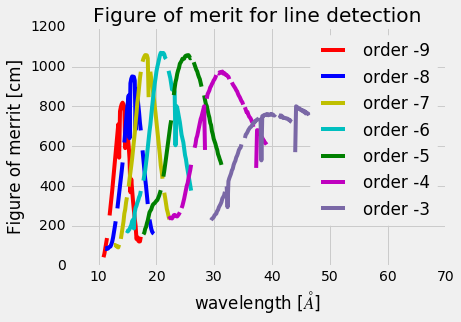

In [18]:
fig, ax = plot_merrit(tper, tper['Aeff4'], tper['R4'])
ax.set_xlim([5, 70])
temp = ax.set_title('Figure of merit for line detection')

The figure of merit for line detection is $\sqrt{R*A_\mathrm{eff}}$. It can be derived from the plots above and is shown here for the most relevant orders. The figure of merit changes with the scientific task at hand (measure line shifts, measure line fluxes), but this particular form is used in the Arcus proposal and thus shown here for illustration.

## Summary

In this memo, I have show the performance of Arcus over the design bandpass of the gratings. These numbers are not perfect and still need to be compared to Casey DeRoo's independent ray-trace effort and this notebook will be updated. Furthermore, the Arcus configuration used in these simulations uses a 1 nm SiO layer on the SPOs for an average reflection angle of 0.8 deg. However, the SiO layer will be thicker (and thus reduce the effective area around the oxygen edge) or might be covered with a coating. Simulation will be updated in the next few weeks to reflect that. 

All the "data behind the figures" is available in a Dropbox account, please contact Moritz for the links.

## Appendix: Comparison to Casey DeRoo raytrace results

In [19]:
ls ../inputdata/

171126_arcusTrace_EffAreaByOrder_CoatingOption1_OC1.csv
171126_arcusTrace_EffAreaByOrder_CoatingOption1_OC2.csv
171126_arcusTrace_EffAreaByOrder_CoatingOption1_OC3.csv
171126_arcusTrace_EffAreaByOrder_CoatingOption1_OC4.csv
171126_arcusTrace_EffAreaByOrder_Uncoated_OC1.csv
171126_arcusTrace_EffAreaByOrder_Uncoated_OC2.csv
171126_arcusTrace_EffAreaByOrder_Uncoated_OC3.csv
171126_arcusTrace_EffAreaByOrder_Uncoated_OC4.csv
171211_ArcusPerf_BaselineCoating_N10^5_OC1.csv
171211_ArcusPerf_BaselineCoating_N10^5_OC2.csv
171211_ArcusPerf_BaselineCoating_N10^5_OC3.csv
171211_ArcusPerf_BaselineCoating_N10^5_OC4.csv
171211_ArcusPerf_Uncoated_N10^5_OC1.csv
171211_ArcusPerf_Uncoated_N10^5_OC2.csv
171211_ArcusPerf_Uncoated_N10^5_OC3.csv
171211_ArcusPerf_Uncoated_N10^5_OC4.csv
Diffuse_mdl_1.csv
Diffuse_mdl_2.csv
Diffuse_mdl_2.csv~
EQPegA_flux.tbl


In [20]:
casey1 = Table.read(os.path.join(get_path('analysisinput'), '171126_arcusTrace_EffAreaByOrder_Uncoated_OC3.csv'),
                                 #'171126_arcusTrace_EffAreaByOrder_Uncoated_OC2.csv'), 
                    format='ascii')
ordinals = ['0th', '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th']
casey1.orders = -np.arange(0, 13)
casey1['Aeff'] = np.vstack([casey1['EA_{}Order'.format(o)] for o in ordinals]).T
casey1['R'] = np.vstack([casey1['Res_{}Order'.format(o)] for o in ordinals]).T
casey1['wave'] *= 10  # nm to Ang

Reading config file with path definitions: ['../site.cfg']


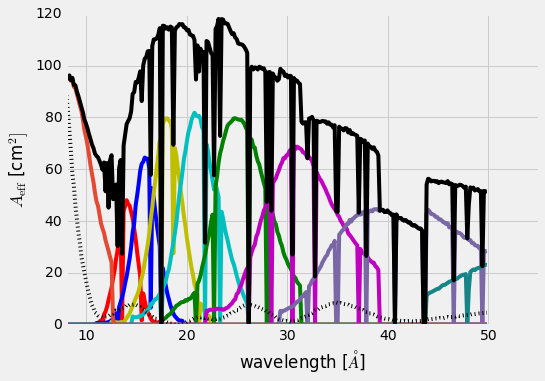

In [21]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 6))
plot_aeff(tper, tper['Aeff'][:, 0, :], np.arange(-9, 1), axes)

axes.set_xlabel('wavelength [$\AA{}$]')    
axes.set_ylabel('$A_\mathrm{eff}$ [cm$^2]$')
fig.subplots_adjust(bottom=0.13, left=0.13, top=.85, wspace=0.1, hspace=0.15)

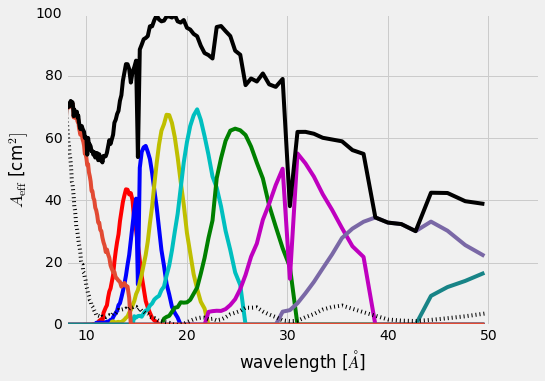

In [22]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 6))
plot_aeff(casey1, casey1['Aeff'], np.arange(-9, 1), axes)

axes.set_xlabel('wavelength [$\AA{}$]')    
axes.set_ylabel('$A_\mathrm{eff}$ [cm$^2]$')
fig.subplots_adjust(bottom=0.13, left=0.13, top=.85, wspace=0.1, hspace=0.15)

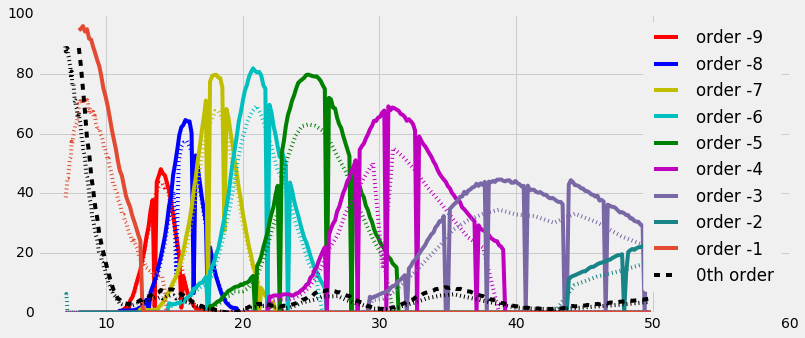

In [23]:
colors = ['r', 'b', 'y', 'c', 'g', 'm', '#7A68A6', '#188487', '#E24A33']

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

for i, o in enumerate(np.arange(-9, 1)): #, colorcycle):
    if o !=0:
        ax.plot(tper['wave'], tper['Aeff'][:, 0, tper.orders == o], label='order {0}'.format(o), c=colors[i])
        ax.plot(casey1['wave'], casey1['Aeff'][:, casey1.orders == o], ':', label='__no_legend__'.format(o), c=colors[i])
    else:
        ax.plot(tper['wave'], tper['Aeff'][:, 0, tper.orders == 0], 'k', label='0th order')
        ax.plot(casey1['wave'], casey1['Aeff'][:, casey1.orders == 0], ':', c='k', label='__no_legend__')

ax.legend()
temp = ax.set_xlim([5, 60])


In [24]:
tper['wave']

8.0
8.15
8.3
8.45
8.6
8.75
8.9
9.05
9.2
9.35
9.5


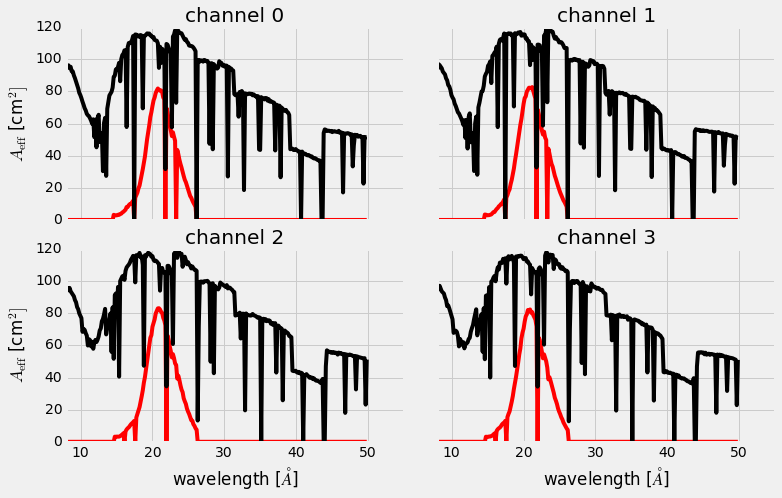

In [25]:
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))
    for i, a in enumerate(apertures):
        ax = axes[np.unravel_index(i, axes.shape)]
        plot_aeff(tper, tper['Aeff'][:, i, :], [-6], ax)
        ax.set_title('channel {}'.format(a))
    for i in [0, 1]:
        axes[1, i].set_xlabel('wavelength [$\AA{}$]')    
        axes[i, 0].set_ylabel('$A_\mathrm{eff}$ [cm$^2]$')
    fig.subplots_adjust(bottom=0.13, left=0.13, top=.85, wspace=0.1, hspace=0.15)

(10, 33)

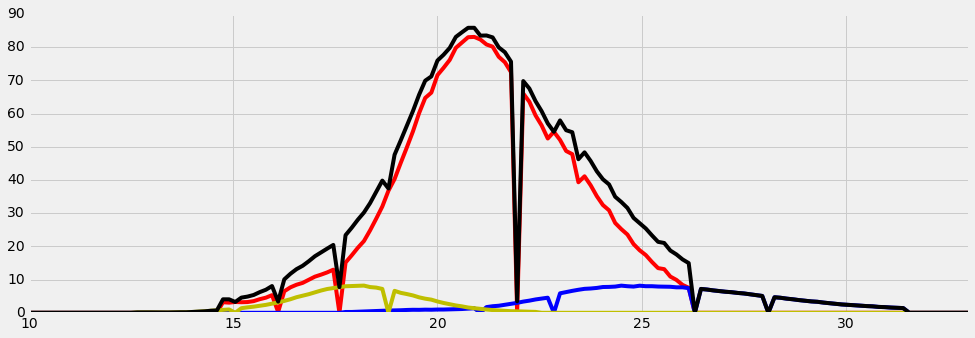

In [26]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.plot(tper['wave'], tper['Aeff'][:, 2, 6])
ax.plot(tper['wave'], tper['Aeff'][:, 2, 7] * 0.10)
ax.plot(tper['wave'], tper['Aeff'][:, 2, 5] * 0.10)
ax.plot(tper['wave'], tper['Aeff'][:, 2, 6] + tper['Aeff'][:, 2, 7] * 0.10 + tper['Aeff'][:, 2, 5] * 0.10, 'k')
ax.set_xlim(10, 33)

In [27]:
tper['Aeff'].shape

(280, 4, 13)

In [28]:
display_codetoggle()